**Trabalho 1 - Visão Computacional 2022/01**

Bruno Baptista Guerra - 2016203441

Thalis Rocha Pestana 

12/06/2022

# Bibliotecas

A partir dos códigos disponibilizados pela professora durante as aulas, importamos todas as bibliotecas na seção abaixo para fins de deixar orginzado em apenas um bloco no *notebook*

In [ ]:
#Bibliotecas para visualização dos dados em 3D
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d    

#Biblioteca para o processamento de arranjos e matrizes, assim como as funções trigonométricas para facilitar a declaração do código
import numpy as np
from math import pi, cos, sin, sqrt, radians
from numpy.linalg import inv

# Funções

## Funções de Movimentação

In [ ]:
def x_rotation(angle):
    a = radians(angle)
    rotation_matrix = np.array([[1,0,0,0],[0, cos(a),-sin(a),0],[0, sin(a), cos(a),0],[0,0,0,1]])
    return rotation_matrix

def y_rotation(angle):
    a = radians(angle)
    rotation_matrix = np.array([[cos(a),0, sin(a),0],[0,1,0,0],[-sin(a), 0, cos(a),0],[0,0,0,1]])
    return rotation_matrix

def z_rotation(angle):
    a = radians(angle)
    rotation_matrix = np.array([[cos(a),-sin(a),0,0],[sin(a),cos(a),0,0],[0,0,1,0],[0,0,0,1]])
    return rotation_matrix

def translation(dx,dy,dz):
    T = np.array([[1,0,0,dx],[0,1,0,dy],[0,0,1,dz],[0,0,0,1]])
    return T

def obj_prepare(obj):
    for i in range(len(obj)):
        obj[i] = np.transpose(obj[i])
        num_columns = np.size(obj[i], 1)
        ones_line = np.ones(num_columns)
        obj[i] = np.vstack([obj[i], ones_line])

def op_World(obj, M, point, base, mov_exec, vis_point=None, ope=None):
    for i in range(3):
        base[i] = np.dot(M, base[i])
        if ope != None:
            vision_base[i] = np.dot(M, vision_base[i])
    
    for i in range(len(obj)):
        obj[i] = np.dot(M,obj[i])
    point = np.dot(M, point)
    mov_exec.append(M)
    
    if ope != None:
        mov_exec_vision.append(M)
        vis_point = np.dot(M, vis_point)
        return mov_exec, point, vis_point
    else: 
        return mov_exec, point

def op_Camera(obj, M, mov_exec, ope=None, point=None, base=None):   
    for i in range(len(obj)):
        for j in range(len(mov_exec)-1,-1,-1):
            obj[i] = np.dot(inv(mov_exec[j]), obj[i])
        obj[i] = np.dot(M, obj[i])
        
        for k in range(len(mov_exec)):
            obj[i] = np.dot(mov_exec[k], obj[i])
    
    if ope != None: 
        for i in range(3):
            for j in range(len(mov_exec)-1,-1,-1):
                base[i] = np.dot(inv(mov_exec[j]), base[i])
            base[i] = np.dot(M, base[i])        
            
            for k in range(len(mov_exec)):
                base[i] = np.dot(mov_exec[k], base[i])
        for j in range(len(mov_exec)-1,-1,-1):
            point = np.dot(inv(mov_exec[j]), point)
            mov_exec_vision.append(inv(mov_exec[j]))
        point = np.dot(M, point)
        mov_exec_vision.append(M)       
        
        for k in range(len(mov_exec)):
            point = np.dot(mov_exec[k], point)
            mov_exec_vision.append(mov_exec[k])   
    return mov_exec, point

def define_initial_base():
  b_world = np.eye(4)[0:3]
  b_obj = np.array([[0,-1,0,0], [1,0,0,0], [0,0,1,0]])
  b_cam = np.array([[0,1,0,0], [0,0,-1,0], [-1,0,0,0]])
  b_vision = np.array([[0,1,0,0], [0,0,-1,0], [-1,0,0,0]])
  return b_world, b_obj, b_cam, b_vision

def define_initial_point():
  p_world = np.array([0,0,0,1])
  p_obj = np.array([0,10,10,1])
  p_cam = np.array([10,10,10,1])
  p_vision = np.array([10,10,10,1])
  return p_world, p_obj, p_cam, p_vision

def define_initial_mov():
  mov_f_obj = [z_rotation(-90), translation(obj_point[0], obj_point[1], obj_point[2])]
  mov_f_cam = [x_rotation(-90), z_rotation(90), translation(cam_point[0], cam_point[1], cam_point[2])]
  mov_v_vis = [x_rotation(-90), rz_rotation(90), translation(vision_point[0], vision_point[1], vision_point[2])]
  return mov_f_obj, mov_f_cam, mov_v_vis

## Funções de Exibição

In [ ]:
def set_plot(ax=None,figure = None,lim=[-2,2]):
    if figure == None:
        figure = plt.figure(figsize=(8,8))
    if ax==None:
        ax = plt.axes(projection='3d')
    
    ax.set_title("camera referecnce")
    ax.set_xlim(lim)
    ax.set_xlabel("x axis")
    ax.set_ylim(lim)
    ax.set_ylabel("y axis")
    ax.set_zlim(lim)
    ax.set_zlabel("z axis")
    return ax

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

def draw_arrows(point,base,axis,length=1.5):  
    # Plot vector of x-axis
    axis.quiver(point[0],point[1],point[2],base[0,0],base[1,0],base[2,0],color='red',pivot='tail',  length=length)
    # Plot vector of y-axis
    axis.quiver(point[0],point[1],point[2],base[0,1],base[1,1],base[2,1],color='green',pivot='tail',  length=length)
    # Plot vector of z-axis
    axis.quiver(point[0],point[1],point[2],base[0,2],base[1,2],base[2,2],color='blue',pivot='tail',  length=length)
    return axis

def obj_show(obj, axis, color='red'):
    for i in range(len(obj)):
      axis.plot3D(obj[i][0,:], obj[i][1,:], obj[i][2,:], color)
    axisEqual3D(axis)

def plot_3D(axis, color1 = 'cyan', color2 = 'black'):
  obj_show(Diamante, axis, color1)
  obj_show(Camera, axis, color2)

  draw_arrows(axis, point_world, base_world)
  draw_arrows(axis, point_obj, base_obj)
  draw_arrows(axis, point_cam, base_cam)
  draw_arrows(axis, point_vision, base_vision)

  axis.set_title('3D points')
  axis.set_xlabel('x-axis')
  axis.set_ylabel('y-axis')
  axis.set_zlabel('z-axis')
  axis.set_xlim([-5,20])
  axis.set_ylim([-5,20])
  axis.set_zlim([-5,20])

def img_show(obj_, axis_I, color = 'red'):
  global m_p_int, m_proj
  obj = list.copy(obj_)
  xdata = []
  ydata = []

  for i in range(len(obj)):
      for j in range(len(mov_exec_vision)-1,-1,-1):
          obj[i] = np.dot(inv(mov_exec_vision[j]), obj[i])
      obj[i] = np.dot(m_p_int, np.dot(m_proj, obj[i]))
      img_aux = obj[i]
      
      for m in range(np.size(obj[i],1)):
          if i != len(obj) -1:
              if img_aux[-1][m] > 0:
                  xdata.append(img_aux[0][m]/img_aux[-1][m])
                  ydata.append(img_aux[1][m]/img_aux[-1][m])
  
  axis_I.plot(xdata, ydata, color)
  axis_I.set_aspect('equal')
  axis_I.set_xlim([0, 640])
  axis_I.set_ylim([480, 0])

# Definições iniciais

## Objetos

In [ ]:
house = np.array([[0,         0,         0],
         [0,  -10.0000,         0],
         [0, -10.0000,   12.0000],
         [0,  -10.4000,   11.5000],
         [0,   -5.0000,   16.0000],
         [0,         0,   12.0000],
         [0,    0.5000,   11.4000],
         [0,         0,   12.0000],
         [0,         0,         0],
  [-12.0000,         0,         0],
  [-12.0000,   -5.0000,         0],
  [-12.0000,  -10.0000,         0],
         [0,  -10.0000,         0],
         [0,  -10.0000,   12.0000],
[-12.0000,  -10.0000,   12.0000],
  [-12.0000,         0,   12.0000],
         [0,         0,   12.0000],
         [0,  -10.0000,   12.0000],
         [0,  -10.5000,   11.4000],
  [-12.0000,  -10.5000,   11.4000],
  [-12.0000,  -10.0000,   12.0000],
  [-12.0000,   -5.0000,   16.0000],
         [0,   -5.0000,   16.0000],
         [0,    0.5000,   11.4000],
  [-12.0000,    0.5000,   11.4000],
  [-12.0000,         0,   12.0000],
  [-12.0000,   -5.0000,   16.0000],
  [-12.0000,  -10.0000,   12.0000],
  [-12.0000,  -10.0000,         0],
  [-12.0000,   -5.0000,         0],
  [-12.0000,         0,         0],
  [-12.0000,         0,   12.0000],
  [-12.0000,         0,         0]])


## Inicialização

In [ ]:
corpoCamera = np.array([    [9.9, 9.7, 9.8],
                            [9.9, 9.7, 10.2],
                            [9.9, 10.3, 10.2],
                            [9.9, 10.3, 9.8],
                            [9.9, 9.7, 9.8],
                            [10.1, 9.7, 9.8],
                            [10.1, 9.7, 10.2],
                            [9.9, 9.7, 10.2],
                            [10.1, 9.7, 10.2],
                            [10.1, 10.3, 10.2],
                            [9.9, 10.3, 10.2],
                            [10.1, 10.3, 10.2],
                            [10.1, 10.3, 9.8],
                            [9.9, 10.3, 9.8],
                            [10.1, 10.3, 9.8],
                            [10.1, 9.7, 9.8]])
lenteCamera = np.array([    [9.9, 9.9, 9.925],
                            [9.9, 9.9, 10.075],
                            [9.9, 10.1, 10.075],
                            [9.9, 10.1, 9.925],
                            [9.9, 9.9, 9.925],
                            [9.85, 9.9, 9.925],
                            [9.85, 9.9, 10.075],
                            [9.9, 9.9, 10.075],
                            [9.85, 9.9, 10.075],
                            [9.85, 10.1, 10.075],
                            [9.9, 10.1, 10.075],
                            [9.85, 10.1, 10.075],
                            [9.85, 10.1, 9.925],
                            [9.9, 10.1, 9.925],
                            [9.85, 10.1, 9.925],
                            [9.85, 9.9, 9.925]])          
centroCamera =  np.array([  [10,  10.,  10]])

In [ ]:
#@title Trabalho 1 - Bruno Guerra & Thalis Rocha
dx_cam = 0 #@param {type:"number"}


In [ ]:
## HOUSE

house = np.array([[0,         0,         0],
         [0,  -10.0000,         0],
         [0, -10.0000,   12.0000],
         [0,  -10.4000,   11.5000],
         [0,   -5.0000,   16.0000],
         [0,         0,   12.0000],
         [0,    0.5000,   11.4000],
         [0,         0,   12.0000],
         [0,         0,         0],
  [-12.0000,         0,         0],
  [-12.0000,   -5.0000,         0],
  [-12.0000,  -10.0000,         0],
         [0,  -10.0000,         0],
         [0,  -10.0000,   12.0000],
[-12.0000,  -10.0000,   12.0000],
  [-12.0000,         0,   12.0000],
         [0,         0,   12.0000],
         [0,  -10.0000,   12.0000],
         [0,  -10.5000,   11.4000],
  [-12.0000,  -10.5000,   11.4000],
  [-12.0000,  -10.0000,   12.0000],
  [-12.0000,   -5.0000,   16.0000],
         [0,   -5.0000,   16.0000],
         [0,    0.5000,   11.4000],
  [-12.0000,    0.5000,   11.4000],
  [-12.0000,         0,   12.0000],
  [-12.0000,   -5.0000,   16.0000],
  [-12.0000,  -10.0000,   12.0000],
  [-12.0000,  -10.0000,         0],
  [-12.0000,   -5.0000,         0],
  [-12.0000,         0,         0],
  [-12.0000,         0,   12.0000],
  [-12.0000,         0,         0]])


house = np.transpose(house)

#add a vector of ones to the house matrix to represent the house in homogeneous coordinates
house = np.vstack([house, np.ones(np.size(house,1))])

#Rotation
rotation_angle = -pi/2 #in radians
Rz = z_rotation(rotation_angle)
#print('Rx:\n',Rx,'\n')

R1 = Rz

house = np.dot(R1, house)

# Translation
translation = np.array([[6.0],[0.0],[0.0],[1.0]])

T1 = np.eye(4)
T1[:,-1]=translation.T

house = np.dot(T1, house)

translation = np.array([[0.0],[5.0],[0.0],[1.0]])

T2 = np.eye(4)
T2[:,-1]=translation.T

house = np.dot(T2, house)

#ax0 = set_plot(lim=[-15,20])
#ax0.plot3D(house[0,:], house[1,:], house[2,:], 'red')
#ax0.scatter(0, 0, 0,'b')

In [ ]:
## CAM FRAME

# base vector values
e1 = np.array([[1],[0],[0],[0]]) # X
e2 = np.array([[0],[1],[0],[0]]) # Y
e3 = np.array([[0],[0],[1],[0]]) # Z
cam_base = np.hstack((e1,e2,e3))

#print ('Cartesian base: \n',base)
#origin point
cam_point =np.array([[0],[-15],[0],[1]])

#print ('Origin: \n',point)

# You can also consider the camera as an object composed by its base and origin
# Then you can transform such object whenever you want to rotate or translate the camera 
cam  = np.hstack([cam_base,cam_point])

#print ('Camera: \n',cam)

In [ ]:
## WORLD FRAME 

world_base = np.hstack((e1,e2,e3))

world_point =np.array([[0],[0],[0],[1]])

world  = np.hstack([world_base,world_point])

In [ ]:
'''rotation_angle_z = (angle_cam_z*pi)/180
rotation_angle_y = (angle_cam_y*pi)/180
rotation_angle_x = (angle_cam_x*pi)/180


Rz_cam = z_rotation(rotation_angle_z)
Ry_cam = y_rotation(rotation_angle_y)
Rx_cam = x_rotation(rotation_angle_x)'''


'rotation_angle_z = (angle_cam_z*pi)/180\nrotation_angle_y = (angle_cam_y*pi)/180\nrotation_angle_x = (angle_cam_x*pi)/180\n\n\nRz_cam = z_rotation(rotation_angle_z)\nRy_cam = y_rotation(rotation_angle_y)\nRx_cam = x_rotation(rotation_angle_x)'

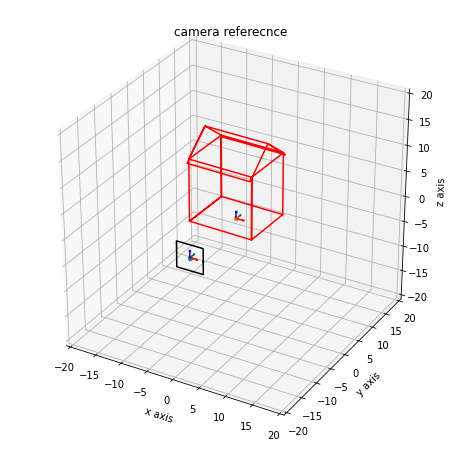

In [ ]:
## CAM

lenteCamera = np.array([[2.5000,  -15.0000,         0],
                  [2.500,  -15.0000,         2.5000],
                  [-2.5000,  -15.0000,         2.5000],
                  [-2.5000,  -15.0000,         -2.5000],
                  [2.5000,  -15.0000,         -2.5000],
                  [2.5000,  -15.0000,         0]])
         
lenteCamera = np.transpose(lenteCamera)

#add a vector of ones to the house matrix to represent the house in homogeneous coordinates
lenteCamera = np.vstack([lenteCamera, np.ones(np.size(lenteCamera,1))])


ax0 = set_plot(lim=[-20,20])
#draw_arrows(point,base,ax0)
ax0.plot3D(lenteCamera[0,:], lenteCamera[1,:], lenteCamera[2,:], 'black')
# Ploting the corner of the house 
ax0.scatter(0, -15, 0,'b')

draw_arrows(cam[:,3],cam[:,0:3],ax0)
#draw_arrows(cam_point,cam_base,ax0)
draw_arrows(world_point,world_base,ax0)


ax0.plot3D(house[0,:], house[1,:], house[2,:], 'red')
ax0.scatter(0, 0, 0,'r')


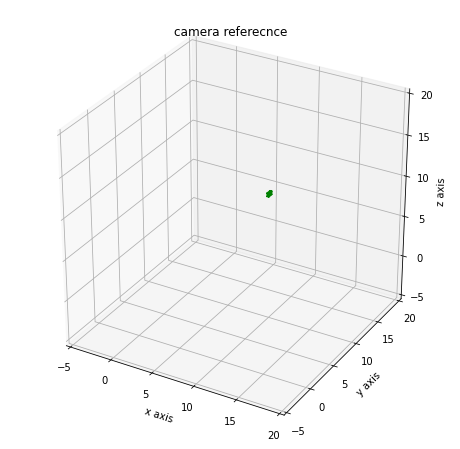

In [ ]:
centroCamera = np.transpose(centroCamera)
lenteCamera = np.transpose(lenteCamera) 
corpoCamera = np.transpose(corpoCamera)

centroCamera = np.vstack([centroCamera, np.ones(np.size(centroCamera,1))])
lenteCamera = np.vstack([lenteCamera, np.ones(np.size(lenteCamera,1))])
corpoCamera = np.vstack([corpoCamera, np.ones(np.size(corpoCamera,1))])

ax0 = set_plot(lim=[-5,20])
#ax0.plot3D(centroCamera[0,:], centroCamera[1,:], centroCamera[2,:], 'red')
#ax0.plot3D(lenteCamera[0,:], lenteCamera[1,:], lenteCamera[2,:], 'blue')
ax0.plot3D(corpoCamera[0,:], corpoCamera[1,:], corpoCamera[2,:], 'green')


